### **Описание датасета**

- **Предметная область:** Химический анализ красных вин и оценка их качества
- **Источник данных:** UCI Machine Learning Repository - реальные данные о винах Vinho Verde
- **Характер данных:** Реальные данные
- **Описание задачи:** Прогнозирование качества вина по химическим показателям

### **Описание атрибутов**

- **fixed acidity** - числовой - фиксированная кислотность (г/л винной кислоты)
- **volatile acidity** - числовой - летучая кислотность (г/л уксусной кислоты)
- **citric acid** - числовой - содержание лимонной кислоты (г/л)
- **residual sugar** - числовой - остаточный сахар (г/л)
- **chlorides** - числовой - содержание хлоридов (г/л хлорида натрия)
- **free sulfur dioxide** - числовой - свободный диоксид серы (мг/л)
- **total sulfur dioxide** - числовой - общий диоксид серы (мг/л)
- **density** - числовой - плотность (г/мл)
- **pH** - числовой - уровень кислотности
- **sulphates** - числовой - содержание сульфатов (г/л сульфата калия)
- **alcohol** - числовой - содержание алкоголя (% об.)
- **quality** - числовой - качество вина (шкала от 0 до 10)
- **total acidity** - числовой - общая кислотность

### **Ход работы:**

#### **Импорт библиотек и загрузка датасета**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')
# Импорт дополнительных библиотек для кластеризации
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm





plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10


path = "/Users/yulia/Desktop/вуз/winequality-red.csv"



with open(path, 'r') as f:
    first_lines = [f.readline().strip() for _ in range(5)]

print("Первые строки файла:")
for i, line in enumerate(first_lines):
    print(f"{i}: {line}")


first_line = first_lines[0]
df = pd.read_csv(path, sep=',')

# 1. Добавление нового атрибута - общей кислотности
# Общая кислотность = фиксированная кислотность + летучая кислотность + лимонная кислота
df['total acidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']

print("\nПервые 5 строк датасета:")
print(tabulate(df.head(), headers='keys', tablefmt='grid', floatfmt=".2f"))

print("Добавлен новый атрибут 'total acidity'")
print(f"Первые 5 строк с новым атрибутом:")
print(tabulate(df[['fixed acidity', 'volatile acidity', 'citric acid', 'total acidity']].head(),
               headers='keys', tablefmt='grid', floatfmt=".2f"))

Первые строки файла:
0: fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1: 7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
2: 7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
3: 7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
4: 11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6

Первые 5 строк датасета:
+----+-----------------+--------------------+---------------+------------------+-------------+-----------------------+------------------------+-----------+------+-------------+-----------+-----------+-----------------+
|    |   fixed acidity |   volatile acidity |   citric acid |   residual sugar |   chlorides |   free sulfur dioxide |   total sulfur dioxide |   density |   pH |   sulphates |   alcohol |   quality |   total acidity |
+====+=================+====================+===============+==================+=============+=======================+=============

### **Среднее значение и СКО атрибутов, поиск пропущенных значений**

In [39]:
stats_df = pd.DataFrame({'Среднее': df.mean(numeric_only=True), 'Среднеквадратичное отклонение': df.std(numeric_only=True),
                         'Количество пропусков': df.isnull().sum(), 'Процент пропусков': (df.isnull().sum() / len(df)) * 100})

print(tabulate(stats_df, headers='keys', tablefmt='grid', floatfmt=".2f"))


+----------------------+-----------+---------------------------------+------------------------+---------------------+
|                      |   Среднее |   Среднеквадратичное отклонение |   Количество пропусков |   Процент пропусков |
+======================+===========+=================================+========================+=====================+
| fixed acidity        |      8.32 |                            1.74 |                   0.00 |                0.00 |
+----------------------+-----------+---------------------------------+------------------------+---------------------+
| volatile acidity     |      0.53 |                            0.18 |                   0.00 |                0.00 |
+----------------------+-----------+---------------------------------+------------------------+---------------------+
| citric acid          |      0.27 |                            0.19 |                   0.00 |                0.00 |
+----------------------+-----------+--------------------


### **Анализ пропущенных значений**

Пропущенных значений в данных не обнаружено. Все записи полные и готовы для дальнейшего анализа.

Если бы пропуски были, то можно было бы применить следующие стратегии обработки:
- Менее 5% пропусков - удалить строки с пропусками
- 5-30% пропусков - использовать методы машинного обучения для импутации или заполнить медианой/средним
- Более 30% пропусков - рассмотреть удаление признака или создание индикаторной переменной

### **Гистограммы распределения**
- Столбцы: количество наблюдений в каждом интервале значений
- Кривая: сглаженная линия, отражающая форму распределения
- Красная пунктирная линия: среднее значение (центр распределения)
- Зеленые пунктирные линии: границы ±1 стандартное отклонение (мера разброса)

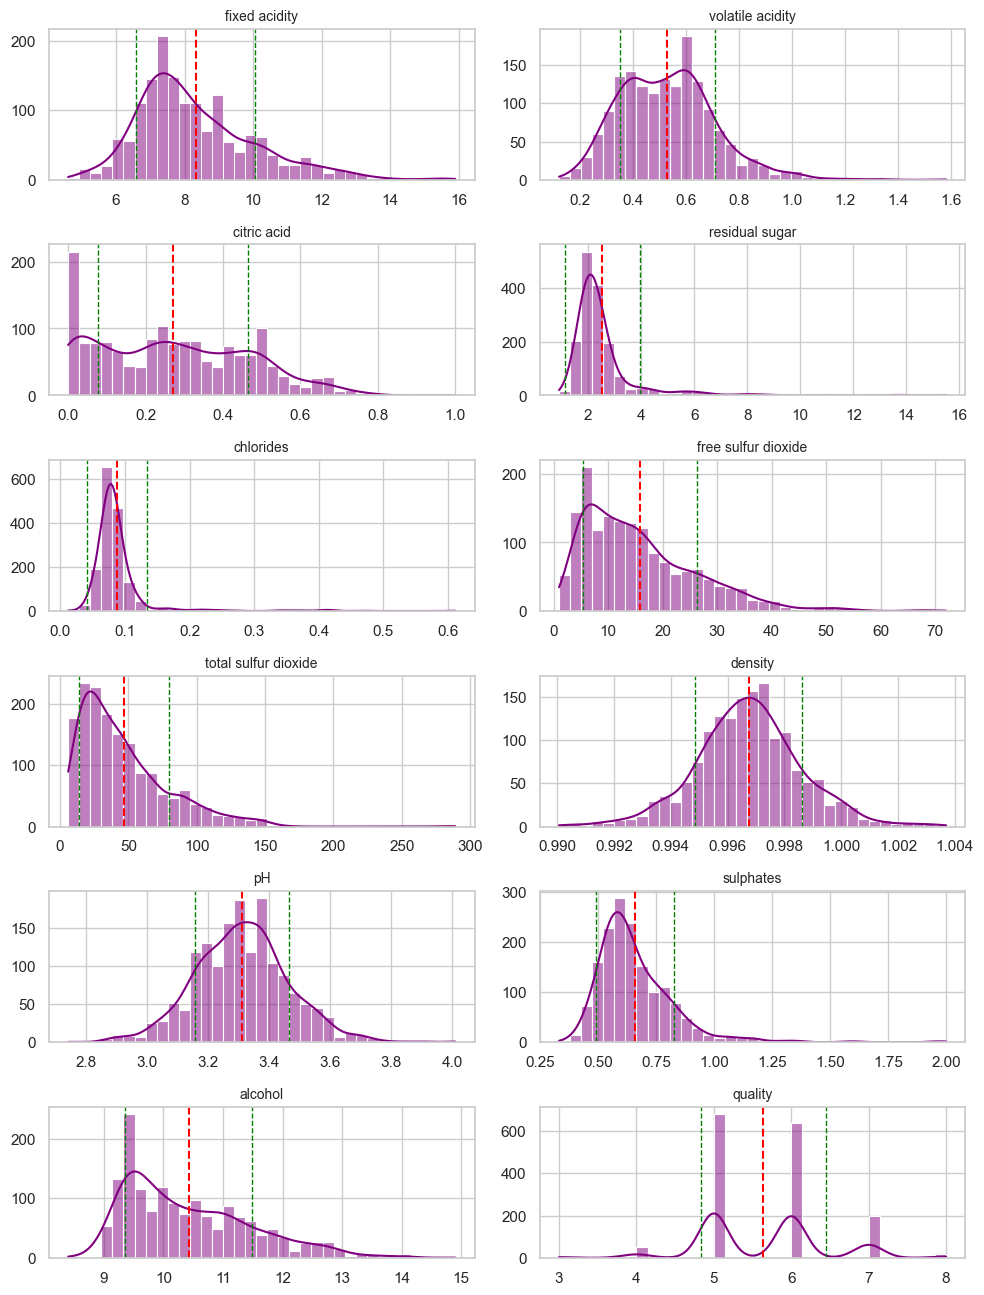

In [43]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 15))

for i, column in enumerate(df.columns, 1):
    plt.subplot(7, 2, i)

    sns.histplot(df[column], kde=True, bins=35, color='purple')

    mean_val = df[column].mean()
    std_val = df[column].std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    plt.axvline(mean_val + std_val, color='green', linestyle='--', linewidth=1)
    plt.axvline(mean_val - std_val, color='green', linestyle='--', linewidth=1)

    plt.title(column, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')

    plt.tight_layout()
    plt.tight_layout()

### **Анализ выбросов**  (Метод межквартильного размаха **IQR**)

In [37]:
outlier_summary = []
for column in df.columns:
    quartile1 = df[column].quantile(0.25)
    quartile3 = df[column].quantile(0.75)
    IQR = quartile3 - quartile1
    lower_bound = quartile1 - 1.5 * IQR
    upper_bound = quartile3 + 1.5 * IQR

    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_percent = len(outliers) / len(df) * 100

    outlier_summary.append({
        'Атрибут': column,
        'Выбросы (кол-во)': len(outliers),
        'Выбросы (%)': f'{outlier_percent:.3f}%',
        'Нижняя граница': lower_bound,
        'Верхняя граница': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Сводка по выбросам:")
print(tabulate(outlier_df, headers='keys', tablefmt='grid', floatfmt=".2f"))



Сводка по выбросам:
+----+----------------------+--------------------+---------------+------------------+-------------------+
|    | Атрибут              |   Выбросы (кол-во) | Выбросы (%)   |   Нижняя граница |   Верхняя граница |
+====+======================+====================+===============+==================+===================+
|  0 | fixed acidity        |                 49 | 3.064%        |             3.95 |             12.35 |
+----+----------------------+--------------------+---------------+------------------+-------------------+
|  1 | volatile acidity     |                 19 | 1.188%        |             0.02 |              1.02 |
+----+----------------------+--------------------+---------------+------------------+-------------------+
|  2 | citric acid          |                  1 | 0.063%        |            -0.40 |              0.91 |
+----+----------------------+--------------------+---------------+------------------+-------------------+
|  3 | residual sugar     

### **Корреляционный анализ**

#### **Матрица корреляций**

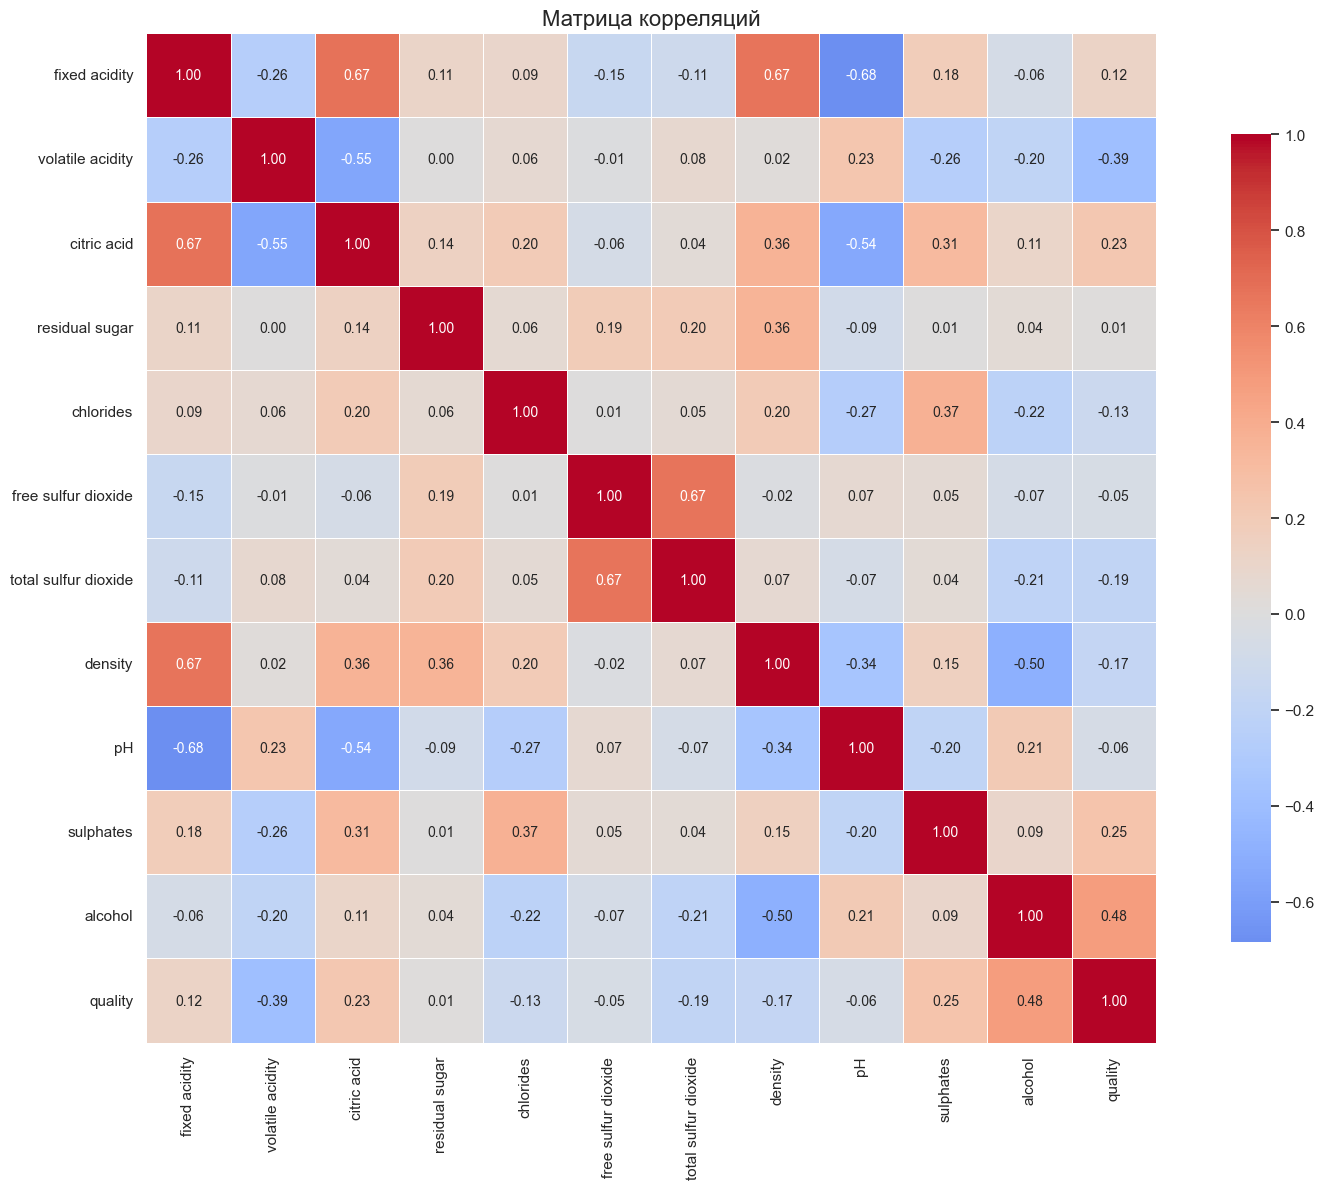

In [63]:
correlation_matrix = df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})
plt.title('Матрица корреляций', fontsize=16)
plt.tight_layout()
plt.show()

**Поиск высокой и низкой корреляции между признаками**

In [80]:
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= 0.5:
            high_corr.append((correlation_matrix.columns[i],
                              correlation_matrix.columns[j],
                              corr_value))

high_corr_sorted = sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)

print("\nВысококоррелированные пары признаков (|r| >= 0.5):\n")
for pair in high_corr_sorted:
    feature1, feature2, corr_value = pair
    correlation_type = "положительная" if corr_value > 0 else "отрицательная"
    strength = "очень сильная" if abs(corr_value) > 0.7 else "сильная"
    print(f" {feature1} - {feature2}:  {corr_value:.3f}  ({strength}  {correlation_type} корреляция)")

print("\n/////////////////////////////////////////////////////////////////////////////////////////////////////////")

weak_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) < 0.1:
            weak_corr.append((correlation_matrix.columns[i],
                             correlation_matrix.columns[j],
                             corr_value))

weak_corr_sorted = sorted(weak_corr, key=lambda x: abs(x[2]))

print("\nПары признаков с очень слабой корреляцией (|r| < 0.1):\n")
for pair in weak_corr_sorted[:20]:
    feature1, feature2, corr_value = pair
    print(f"{feature1} - {feature2}: {corr_value:.3f}")


Высококоррелированные пары признаков (|r| >= 0.5):

 fixed acidity - pH:  -0.683  (сильная  отрицательная корреляция)
 fixed acidity - citric acid:  0.672  (сильная  положительная корреляция)
 fixed acidity - density:  0.668  (сильная  положительная корреляция)
 free sulfur dioxide - total sulfur dioxide:  0.668  (сильная  положительная корреляция)
 volatile acidity - citric acid:  -0.552  (сильная  отрицательная корреляция)
 citric acid - pH:  -0.542  (сильная  отрицательная корреляция)

/////////////////////////////////////////////////////////////////////////////////////////////////////////

Пары признаков с очень слабой корреляцией (|r| < 0.1):

volatile acidity - residual sugar: 0.002
residual sugar - sulphates: 0.006
chlorides - free sulfur dioxide: 0.006
volatile acidity - free sulfur dioxide: -0.011
residual sugar - quality: 0.014
free sulfur dioxide - density: -0.022
volatile acidity - density: 0.022
citric acid - total sulfur dioxide: 0.036
residual sugar - alcohol: 0.042
tot

###  **Пары признаков с наименьшей средней корреляцией**

In [78]:
mean_correlation = correlation_matrix.abs().mean().sort_values()

print("\nПризнаки с наименьшей средней корреляцией с другими признаками:\n")
print(mean_correlation.head(10))


Признаки с наименьшей средней корреляцией с другими признаками:

residual sugar          0.184019
free sulfur dioxide     0.195800
chlorides               0.221197
total sulfur dioxide    0.226229
sulphates               0.243192
volatile acidity        0.255801
quality                 0.256633
alcohol                 0.265309
pH                      0.312423
density                 0.322121
dtype: float64


### **Матрицы графиков рассеивания**

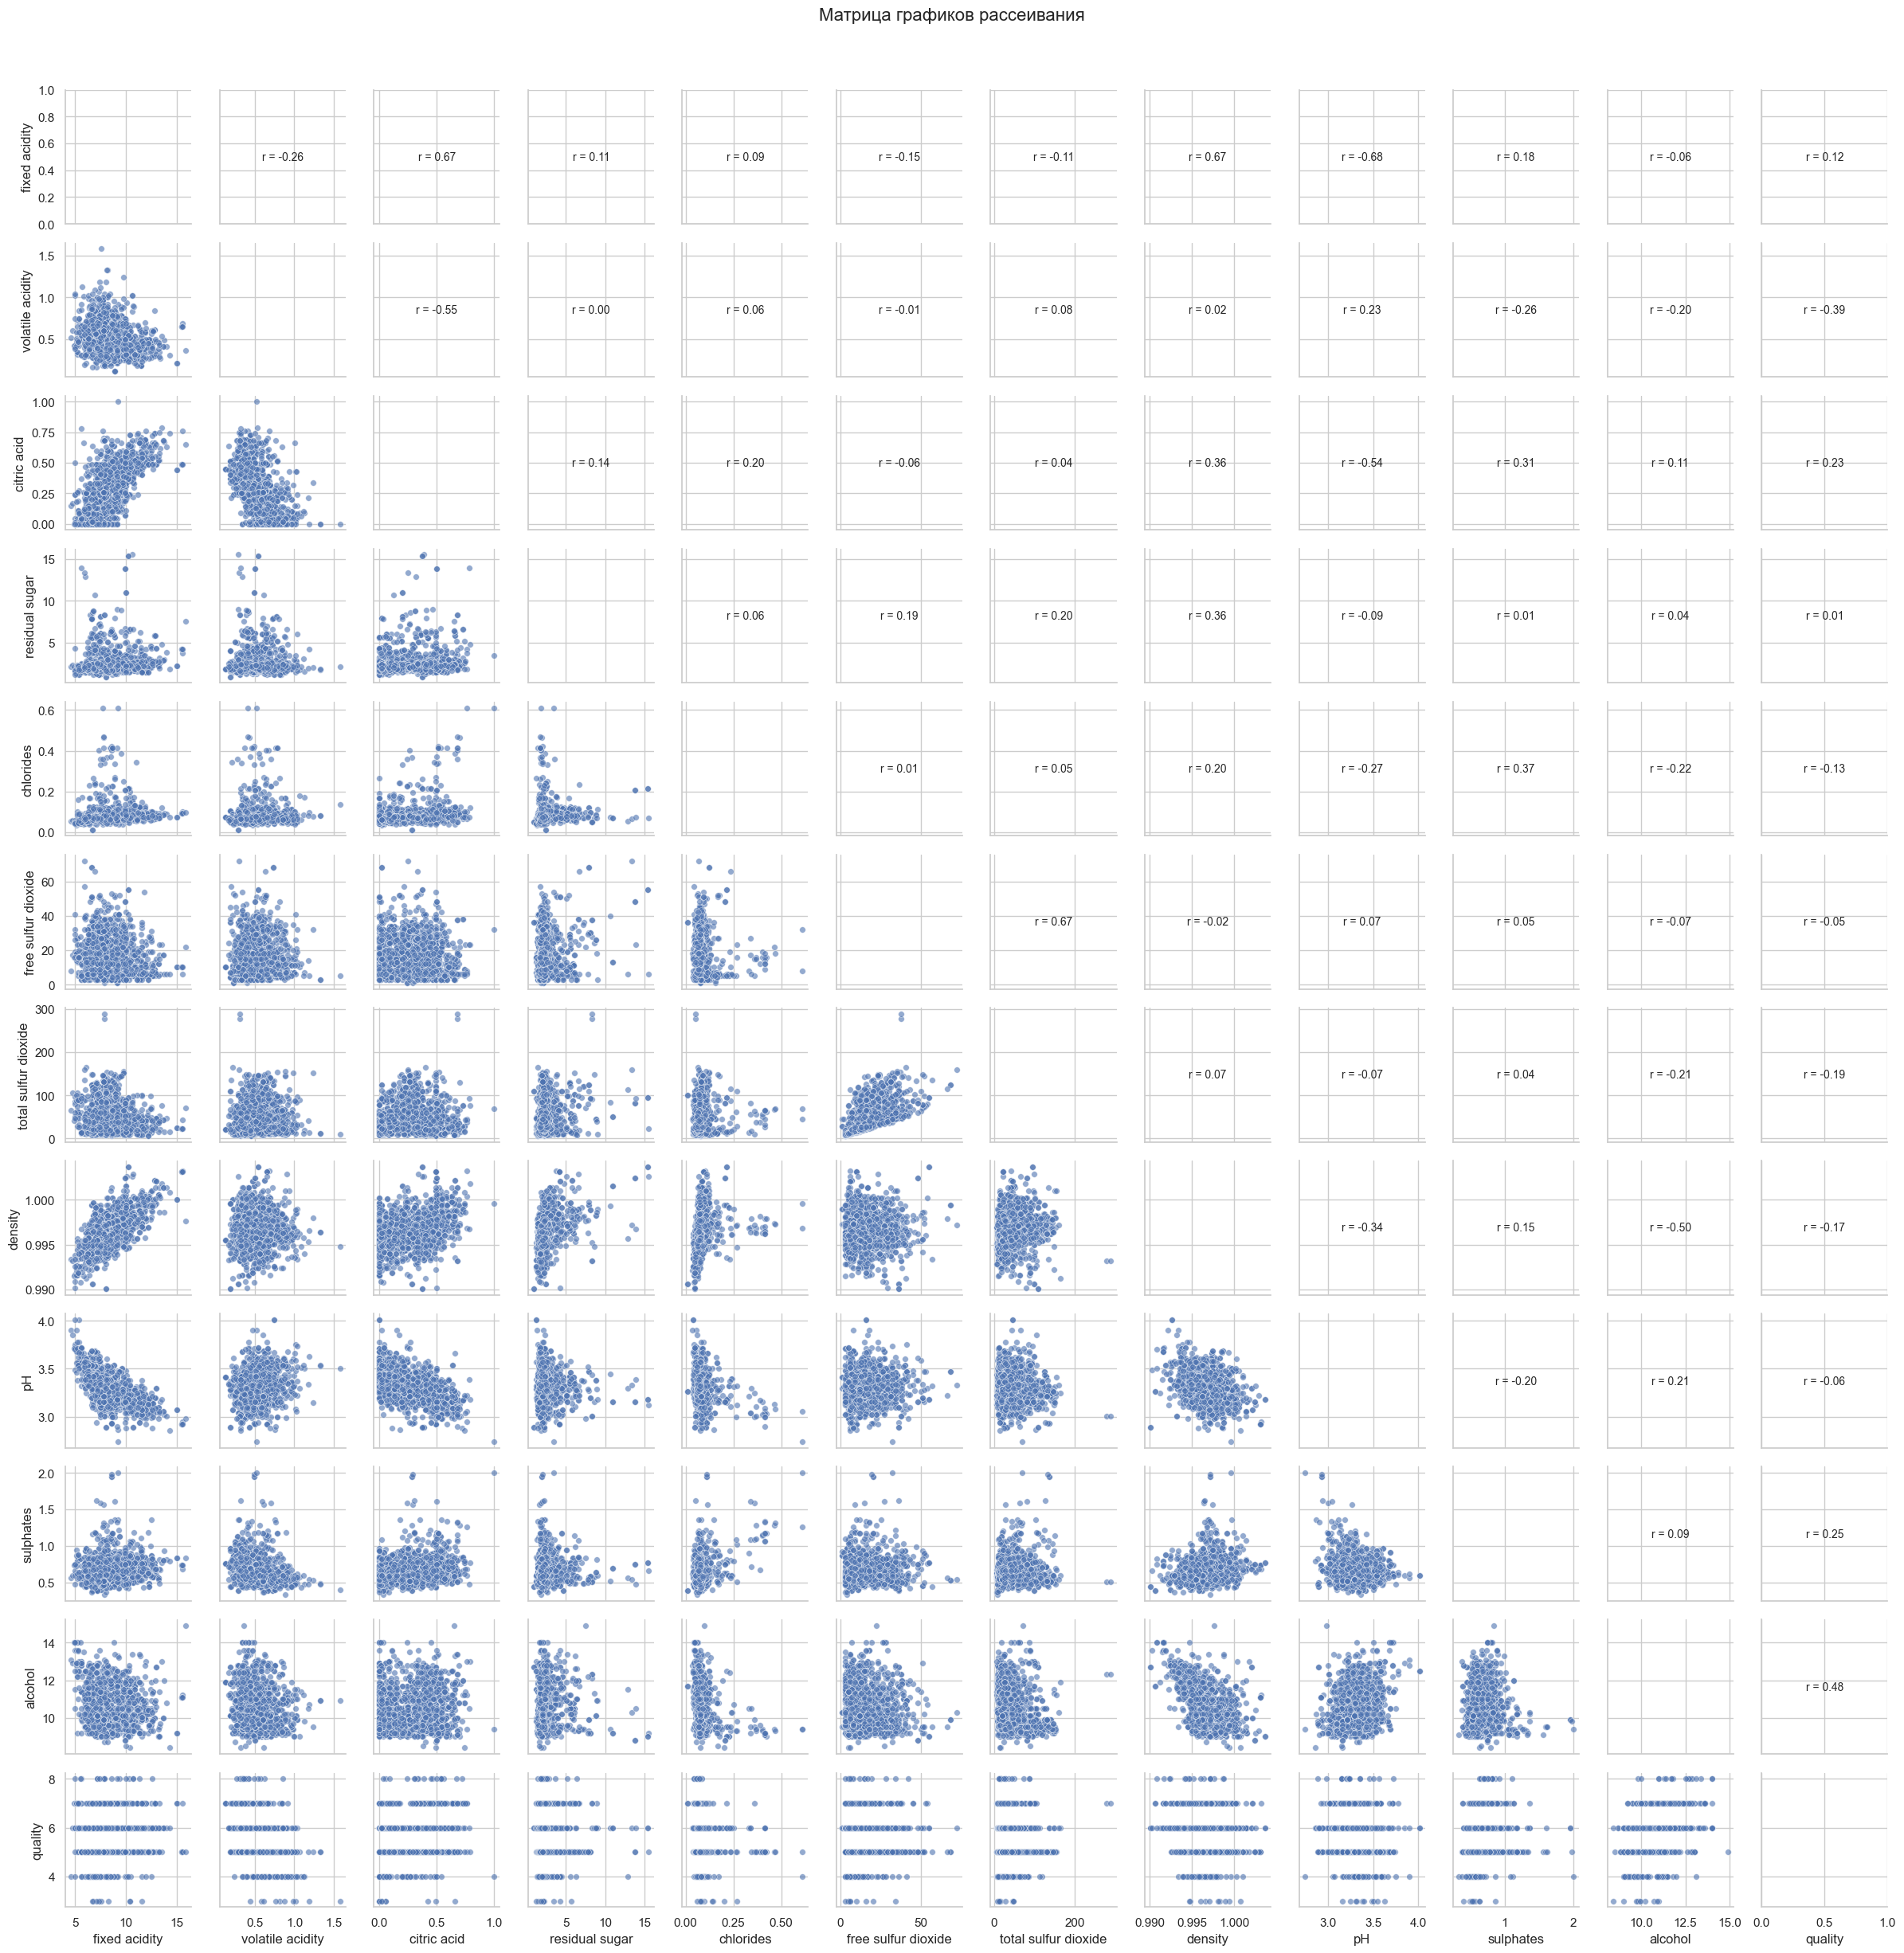

In [82]:
g = sns.PairGrid(df, diag_sharey=False, height=2)
g.map_lower(sns.scatterplot, alpha=0.6, s=30)
g.map_upper(lambda x, y, **kws: plt.gca().text(0.5, 0.5,
              f"r = {df[x.name].corr(df[y.name]):.2f}",
              transform=plt.gca().transAxes,
              ha='center', va='center', fontsize=10))

plt.suptitle('Матрица графиков рассеивания', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### **Анализ данных:**

- Чем выше содержание алкоголя, тем лучше качество
- Чем ниже летучая кислотность, тем лучше качество
- Чем ниже плотность, тем лучше качество
- Чем больше содержание сульфатов, тем лучше качество
- Чем меньше содержание хлоридов, тем лучше качество